Combine PKE textrank and word2vec N-gram
Feature 

V1 Feature
- Membuat jalan program
- Ada deteksi unigram/bigram/trigram

V2
- filter jika kata tidak ada dalam model embedding w2v
- implementasi stopwords

V3
- deteksi bigram dari frekuency lebih dari 2x

V4
- detection bigram and trigram using nlp-id
- preprocessing tanpa stopwords

V5
- unigram and trigram di normalize hurufnya
- score jika kata ada dalam judul

V6
- membuat filter Verb dan Noun dari nlp-id, masih ada bug
- Minimize user warning
- running time 30 data : 66s
- Solve bagian preprocessing, untuk menjadi kecil semua
- tambahkan progress bar di main process

V7
- perbaiki bug di fungsi filter_tokens_by_pos, agar tidak ada konversi ke sentence
- perbaiki fungsi write excel #blm berfungsi
- membuat visualisasi dalam graph

V8
- perbaikan dalam fungsi 'get_phrase_embedding' agar word dengan vector 0 tidak masuk dalam process selanjutnya
- 

1. Imports & Setup

In [2]:
#1. rutin1 import module
import pandas as pd
import os
import sys
import warnings
import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import cosine_similarity

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
#2. rutin2 membuat syspath ke root utk aktifkan __init__.py
repo_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
sys.path.append(repo_root)

2. Load Dataset

In [4]:
#3. rutin3 Load the dataset
#dataset_path = os.path.join(repo_root, "notebooks/postager_nlp-id/dataset_ekstraksi_r29_pos_sm.xlsx")
dataset_path = os.path.join(repo_root, "data/dataset_ekstraksi_r29_sm.xlsx")
df = pd.read_excel(dataset_path)
df["text"] = df["judul"] +". "+ df["isi"]
#df_pos = df['pos_sentence_list']

In [5]:
# Preprocess
import re
def preprocess(text):
    text = re.sub(r"\b[a-zA-Z]\b", "", text)
    text = text.replace('.', '. ')
    text = re.sub('[^a-zA-Z.]', ' ', text)
    text = text.lower()
    text = re.sub("(\\d|\\W)+"," ",text)
    text = text.strip()

    return text

df["text"] = df['text'].apply(preprocess)
df["judul"] = df["judul"].apply(preprocess)

3. Process

In [6]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx

from nltk.util import ngrams

def generate_ngrams(words, n=2):
    """Generate ngrams from a list of words."""
    return [" ".join(gram) for gram in ngrams(words, n)]

def get_phrase_embedding(phrase, w2v_model):
    """Get the averaged word embedding for a phrase."""
    words = phrase.split()
    embeddings = [w2v_model.wv[word] for word in words if word in w2v_model.wv.key_to_index]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return None

from collections import Counter
from nlp_id.tokenizer import PhraseTokenizer 
from nlp_id.postag import PosTag


model_path = os.path.join(repo_root, "notebooks/nlp-id_retraining/train_tuned.pkl") #add_8

def detect_bigram(text, available_tokens,):
    
    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only bigrams whose individual words are in available_tokens
    bigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 1 and all(word in available_tokens for word in phrase.split())]

    return bigrams_only

def detect_trigram(text, available_tokens):

    tokenizer = PhraseTokenizer()
    phrases = tokenizer.tokenize(text)
    # Include only trigrams whose individual words are in available_tokens
    trigrams_only = [phrase for phrase in phrases if phrase.count(" ") == 2 and all(word in available_tokens for word in phrase.split())]

    return trigrams_only

def get_unique_tokens_pos(all_tokens, model_path):
    """
    Get unique POS tags for tokens.
    """
    postagger = PosTag(model_path)
    pos_tokens = []
    seen_tokens = set()
    
    for token in all_tokens:
        if token not in seen_tokens:
            seen_tokens.add(token)
            tokens_pos = postagger.get_phrase_tag(token)
            pos_tokens.append(tokens_pos)
    return pos_tokens


def flatten_list_of_lists(list_of_lists):
    """
    Flatten a list of lists into a single list.
    """
    return [item for sublist in list_of_lists for item in sublist]


def filter_tokens_by_pos(flat_tokens, pos_filters):
    """
    Filter tokens based on their POS tags and ensure they're unique.
    """
    seen_tokens = set()
    return [token[0] for token in flat_tokens if token[1] in pos_filters and not (token[0] in seen_tokens or seen_tokens.add(token[0]))]

def extract_keyphrases_with_ngrams_graph(text, w2v_model, judul, available_tokens, n=3):
    # Read stopwords from the file
    #stopwords_path = os.path.join(repo_root, "data/all_stop_words.txt") 
    stopwords_path = os.path.join(repo_root, "notebooks/stopwords_tuning/all_stop_words.txt")
    with open(stopwords_path, 'r') as file:
        stopwords = set(file.read().strip().splitlines())

    # Tokenize the text into unigrams
    #unigrams = [word for word in text.split() if word not in stopwords]

    # Tokenize the text into unigrams that are in available_tokens
    unigrams = [word for word in text.split() if word not in stopwords and word in available_tokens]

    # Generate bigrams and trigrams using nlp-id
    bigrams = detect_bigram(text, available_tokens)
    trigrams = detect_trigram(text, available_tokens)
    
    # Combine unigrams, filtered bigrams, and filtered trigrams
    all_tokens = unigrams + bigrams + trigrams

    # Filter tokens only for selected POS
    pos_tokens = get_unique_tokens_pos(all_tokens, model_path)
    flat_pos_tokens = flatten_list_of_lists(pos_tokens)
    selected_pos = {'NN', 'NNP', 'VB', 'NP', 'VP'} # FW di exclude
    filtered_tokens = filter_tokens_by_pos(flat_pos_tokens, selected_pos)

    # Get embeddings for each token (averaging word embeddings for bigrams/trigrams)
    token_embeddings = [get_phrase_embedding(token, w2v_model) for token in filtered_tokens]
    
    # Filter out tokens that don't have embeddings
    tokens, embeddings = zip(*[(token, emb) for token, emb in zip(filtered_tokens, token_embeddings) if emb is not None])
    # todo : masih ada token bahasa asing atau token aneh yg lolos. 

    # Compute the cosine similarity between token embeddings
    cosine_matrix = cosine_similarity(embeddings)
    
    # Create a graph and connect tokens with high similarity
    G = nx.Graph()
    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if cosine_matrix[i][j] > 0.5:  # This threshold can be adjusted
                G.add_edge(tokens[i], tokens[j], weight=cosine_matrix[i][j])
    
    # Create labels dictionary using the tokens
    labels = {token: token for token in tokens}

    # Compute the PageRank scores to rank the tokens
    scores = nx.pagerank(G)

    # Modify scores if token is in title letter
    for token in scores:
        if any(token in title for title in judul):
            scores[token] *= 2

    # Extract top N keyphrases along with their scores
    ranked_tokens = sorted(((scores[token], token) for token in tokens if token in scores), reverse=True)
    
    keyphrases_with_scores = []
    seen_tokens = set()  # Set to keep track of tokens that have already been added

    for score, token in ranked_tokens:
        if token not in seen_tokens:
            keyphrases_with_scores.append((token, score))
            seen_tokens.add(token)  # Mark the token as seen
            if len(keyphrases_with_scores) >= n:
                break  # Stop when the desired number of keyphrases is reached

    return keyphrases_with_scores, G, labels


def visualize_graph(G, labels):

    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels)
    plt.show()

In [7]:
#w2v_path = os.path.join(repo_root, "models/w2v_100/idwiki_word2vec_100_new_lower.model")
w2v_path = os.path.join(repo_root, "models/w2v_200/idwiki_word2vec_200_new_lower.model")
w2v_model = Word2Vec.load(w2v_path)

# Get available tokens from the Word2Vec model
available_tokens = set(w2v_model.wv.key_to_index)

multitext

In [8]:
predict_textrank = pd.DataFrame()
for i in df.index:
    print('Processing index', i, end='...! ')
    text = df["text"][i] # sblm di preprocess
    #text = df_tr[i] # setelah di preprocess
    ls_judul = preprocess(df["judul"][i]).split()
    keyphrases,_,_ = extract_keyphrases_with_ngrams_graph(text, w2v_model, ls_judul, available_tokens, 3)
    df_keyphrases = pd.DataFrame(keyphrases, columns=['Keyword', 'Score'])
    a = pd.DataFrame(df_keyphrases.Keyword).T.reset_index(drop=True)
    b = pd.DataFrame(df_keyphrases.Score).round(3).T.reset_index(drop=True)
    df_keyphrases = pd.concat([a, b], axis=1)

    # Check if there are missing columns and add them with zero values
    missing_columns = 6 - df_keyphrases.shape[1]
    for _ in range(missing_columns):
        df_keyphrases[df_keyphrases.shape[1]] = 0

    df_keyphrases.columns = ['key_1', 'key_2','key_3','score_1', 'score_2','score_3']
    predict_textrank = pd.concat([predict_textrank, df_keyphrases], ignore_index=True)
    print('Done')
predict_textrank.head(3)

Processing index 0...! Done
Processing index 1...! Done
Processing index 2...! Done
Processing index 3...! Done
Processing index 4...! Done
Processing index 5...! Done
Processing index 6...! Done
Processing index 7...! Done
Processing index 8...! Done
Processing index 9...! Done
Processing index 10...! Done
Processing index 11...! Done
Processing index 12...! Done
Processing index 13...! Done
Processing index 14...! Done
Processing index 15...! Done
Processing index 16...! Done
Processing index 17...! Done
Processing index 18...! Done
Processing index 19...! Done
Processing index 20...! Done
Processing index 21...! Done
Processing index 22...! Done
Processing index 23...! Done
Processing index 24...! Done
Processing index 25...! Done
Processing index 26...! Done
Processing index 27...! Done
Processing index 28...! Done


,key_1,key_2,key_3,score_1,score_2,score_3
0,usulan,personnel,proposed,0.041,0.030,0.030
1,document,project,facilities,0.151,0.133,0.083
2,ruang,usulan,ruangan,0.041,0.040,0.035


EVALUATION

In [9]:
from utils import eval

targets = df[["k1", "k2", "k3","k4", "k5", "k6","k7"]].values.tolist()
df_targets = pd.DataFrame(targets)

In [10]:
# Evaluation TextRank
predict_textrank_list = predict_textrank[['key_1','key_2','key_3']].values.tolist()
eval_textrank = eval(predict_textrank_list, targets, True).round(3)
eval_textrank.columns = ['key_1', 'key_2','key_3','strict_recall', 'strict_prec', 'flex_recall','flex_prec']
eval_textrank = eval_textrank[['key_1', 'key_2','key_3', 'flex_recall','flex_prec']] # untuk menyederhanakan hasil evaluasi
eval_textrank.head(3)

,key_1,key_2,key_3,flex_recall,flex_prec
0,full_match,no_match,no_match,0.143,0.333
1,partial_match,no_match,no_match,0.143,0.333
2,partial_match,no_match,no_match,0.143,0.333


In [11]:
# Calculate TextRank Score, using flexible score : exact maatch =1, partial match = 1, no match = 0
textrank_recall = eval_textrank['flex_recall'].mean()
textrank_prec = eval_textrank['flex_prec'].mean()
textrank_f1 = 2 * (textrank_prec * textrank_recall) / (textrank_prec + textrank_recall)

# Create a DataFrame with the scores
summary = pd.DataFrame({'textrank': [textrank_recall, textrank_prec, textrank_f1]}, index=['recall', 'precision', 'F1'])
summary = summary.round(3)
summary

,textrank
recall,0.133
precision,0.310
F1,0.186


In [12]:
# Combine dataframe predict_textrank, df_targets and eval_textrank
predict_textrank = pd.concat([predict_textrank, df_targets, eval_textrank], axis=1)
predict_textrank.head(3)

,key_1,key_2,key_3,score_1,score_2,score_3,0,1,2,3,4,5,6,key_1,key_2,key_3,flex_recall,flex_prec
0,usulan,personnel,proposed,0.041,0.030,0.030,persetujuan tertulis,prosedur,usulan,pengganti,NaN,NaN,NaN,full_match,no_match,no_match,0.143,0.333
1,document,project,facilities,0.151,0.133,0.083,template document,exhibit c,acuan,pengelolaan,dokumen,NaN,NaN,partial_match,no_match,no_match,0.143,0.333
2,ruang,usulan,ruangan,0.041,0.040,0.035,ruang kantor,change inquiry,lingkup kerja,akomodasi,services for company,exhibit a,NaN,partial_match,no_match,no_match,0.143,0.333


In [13]:
# Write predictions to excel file
from utils import write_excel

sheet_name = 'w2v_tr_phrase'
output_file = 'w2v_textrank_ngram_v8.xlsx'
write_excel(predict_textrank, sheet_name, output_file)

/Users/jim/Documents/GitHub/kw_ina_extraction/utils/ia_file_operation.py:16: FutureWarning: Setting the `book` attribute is not part of the public API, usage can give unexpected or corrupted results and will be removed in a future version
  writer.book = book
/Users/jim/Documents/GitHub/kw_ina_extraction/utils/ia_file_operation.py:25: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


Visualisasi

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

G = nx.Graph()
labels = {}

# sample data untuk digambarkan
text = df["text"][10]
judul = df["judul"][10]

#Add nodes and edges to G and define labels as needed
predict_textrank = pd.DataFrame()
ls_judul = judul.split()

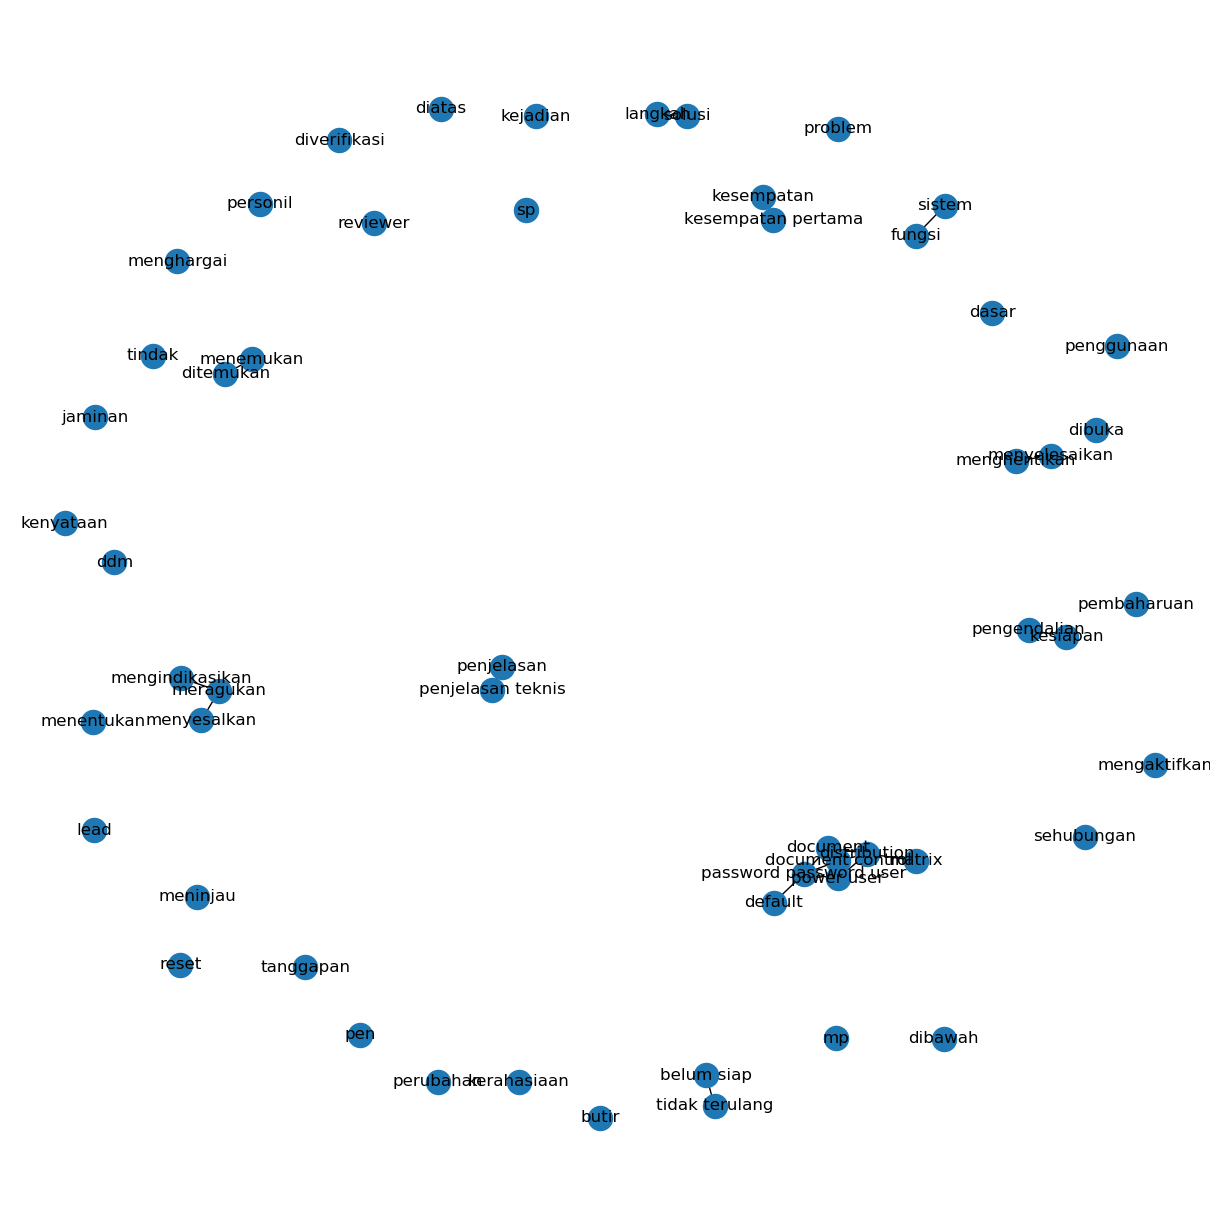

In [15]:
keyphrases, G, labels = extract_keyphrases_with_ngrams_graph(text, w2v_model, ls_judul, available_tokens, 3)
df_keyphrases = pd.DataFrame(keyphrases, columns=['Keyword', 'Score'])
a = pd.DataFrame(df_keyphrases.Keyword).T.reset_index(drop=True)
b = pd.DataFrame(df_keyphrases.Score).round(3).T.reset_index(drop=True)
df_keyphrases = pd.concat([a, b], axis=1)

# Check if there are missing columns and add them with zero values
missing_columns = 6 - df_keyphrases.shape[1]
for _ in range(missing_columns):
    df_keyphrases[df_keyphrases.shape[1]] = 0

df_keyphrases.columns = ['key_1', 'key_2','key_3','score_1', 'score_2','score_3']
predict_textrank = pd.concat([predict_textrank, df_keyphrases], ignore_index=True)

# Call the visualize_graph function to display the graph
visualize_graph(G, labels)

In [16]:
top3_list = predict_textrank[['key_1', 'key_2', 'key_3']].values.tolist()[0]
top3_list

['kesiapan', 'meragukan', 'document control']

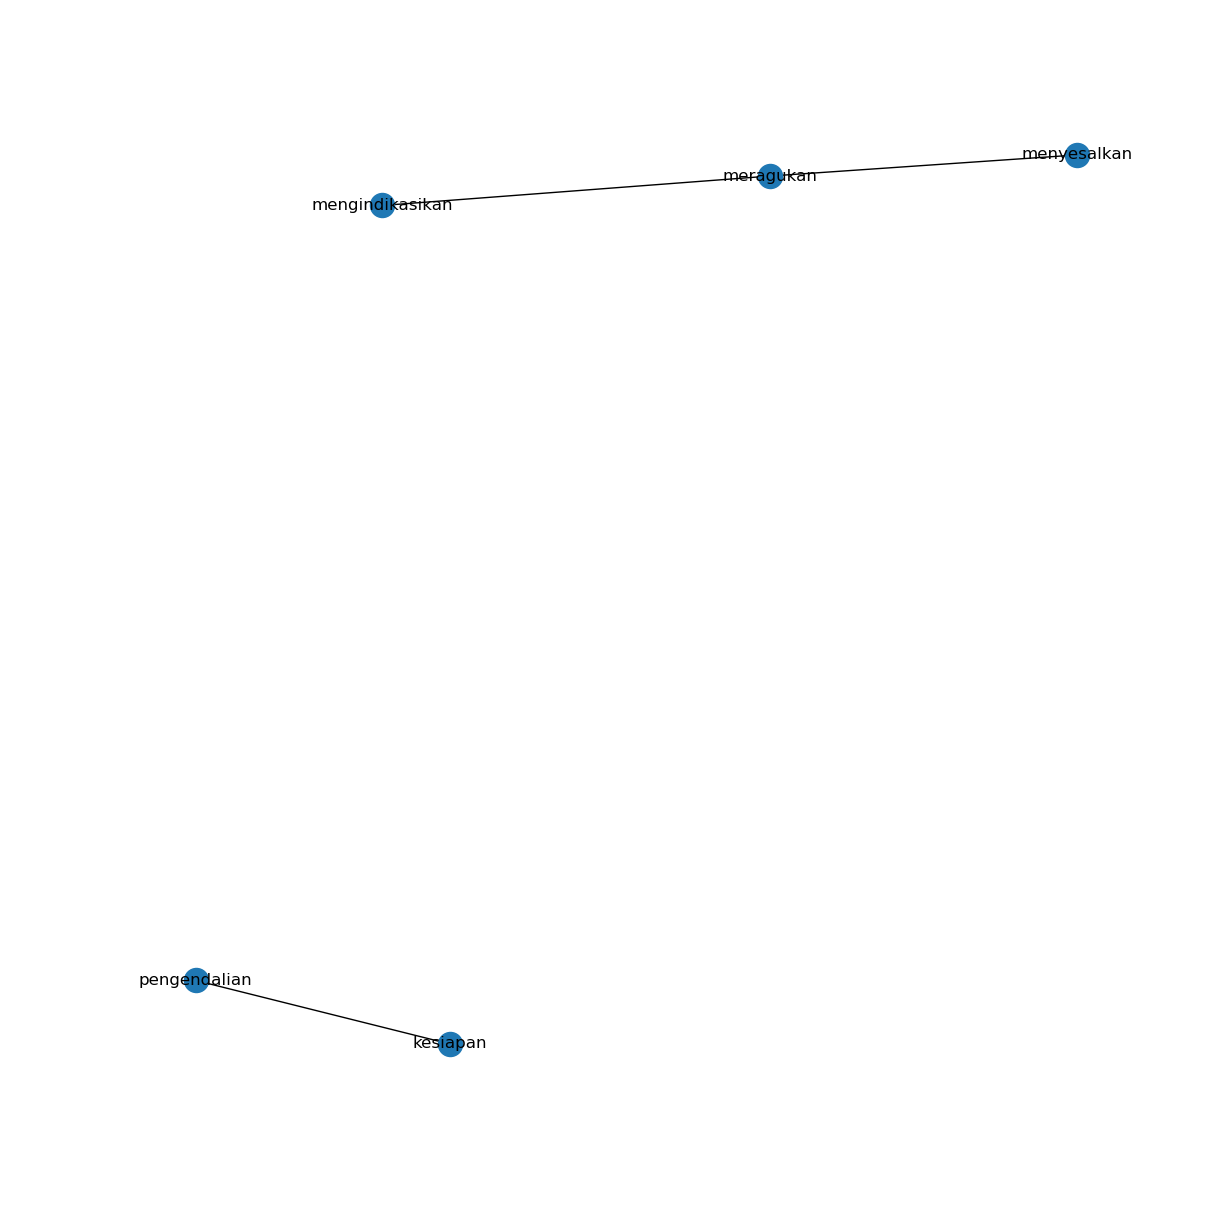

In [17]:
def visualize_graph_focus(G, labels, focus_nodes=None):
    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels)
    
    # If focus_nodes are provided, adjust the plot limits to zoom into that region
    if focus_nodes:
        x_values = [pos[node][0] for node in focus_nodes]
        y_values = [pos[node][1] for node in focus_nodes]
        margin = 0.1  # You can adjust this value for more or less zoom
        plt.xlim(min(x_values) - margin, max(x_values) + margin)
        plt.ylim(min(y_values) - margin, max(y_values) + margin)
    
    plt.show()

# Call the visualize_graph function to display the graph
visualize_graph_focus(G, labels, ['kesiapan','meragukan'])

In [18]:
def visualize_graph(G, labels, focus_nodes=None):
    # Remove self-loops (edges that connect a node to itself)
    G.remove_edges_from(nx.selfloop_edges(G))

    fig = plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(G)
    nx.draw(G, pos=pos, with_labels=False, font_weight="bold")
    nx.draw_networkx_labels(G, pos, labels)
    
    # If focus_nodes are provided, adjust the plot limits to zoom into that region
    if focus_nodes:
        x_values = [pos[node][0] for node in focus_nodes]
        y_values = [pos[node][1] for node in focus_nodes]
        margin = 0.1  # You can adjust this value for more or less zoom
        plt.xlim(min(x_values) - margin, max(x_values) + margin)
        plt.ylim(min(y_values) - margin, max(y_values) + margin)
    
    plt.show()

In [19]:
#melihat list token untuk pengecheckan kenapa ada token bahasa asing masih masuk.
with open('available_tokens.txt', 'w') as file:
    for token in available_tokens:
        file.write(token + '\n')

to do next additional : 
- variasi menggunakan Glove atau vector yg labih tinggi
- beberapa kata foreign word seharusnya tidak ada dalam model w2v bahasa indonesia, tetapi masih lolos. untuk di check vector yg zero agar tidak masuk dalam process selanjutnya. modifikasi perlu dilakukan dalam fungsi "get_phrase_embedding"
